### Import and init GPU

In [1]:
from IPython.display import Audio

In [2]:
import sys
sys.path.append('../../../')

In [3]:
import numpy as np
import math

%matplotlib inline
import matplotlib.pyplot as plt

import pickle
import argparse
import time
import itertools
from copy import deepcopy
import tensorflow as tf

from tuner import HyperparameterTuner
from tuner import MyTask

use_tpu = False
use_gpu = True

if use_tpu:
    from tensorflow.contrib import tpu
    from tensorflow.contrib.cluster_resolver import TPUClusterResolver

if use_gpu:
    import os
    
%load_ext autoreload
%autoreload 2

In [4]:
if use_gpu:
    os.environ['CUDA_VISIBLE_DEVICES'] = '1'
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True

In [5]:
if use_tpu:
    tpu_cluster = TPUClusterResolver(tpu=[tpu_name]).get_master()
    sess = tf.Session(tpu_cluster)
    sess.run(tpu.initialize_system())
elif use_gpu:
    sess = tf.Session(config=config)
else:
    sess = tf.Session()

In [6]:
from resnet import Network

In [7]:
network = Network()

In [8]:
task_home = ''
if use_tpu:
    pass
#     task_home = 'gs://continual_learning/permMNIST_EWC/'
else:
    task_home = '../../../../'

cur_dir = './'
checkpoint_path = cur_dir + 'checkpoints_5_0/'
summaries_path = cur_dir + 'summaries_5_0/'
data_path = task_home + 'cifar-100-python/'
split_path = './split.txt' 
if use_tpu:
    tpu_name = 'gectpu'
    
BATCH_SIZE = 128

### Dataset loading functions

In [9]:
label_smooth_param = 0

def splitDataset(dataset, dataset_split, seed):
    np.random.seed(seed)
    task_list = []
    train_labels = np.argmax(dataset.train.labels, axis=1)
    validation_labels = np.argmax(dataset.validation.labels, axis=1)
    test_labels = np.argmax(dataset.test.labels, axis=1)
    for i in range(len(dataset_split)):
        cur_train_indices = [False] * dataset.train.images.shape[0]
        cur_validation_indices = [False] * dataset.validation.images.shape[0]
        cur_test_indices = [False] * dataset.test.images.shape[0]
        for j in range(len(dataset_split[i])):
            cur_train_indices = np.logical_or(cur_train_indices, (train_labels == dataset_split[i][j]))
            cur_validation_indices = np.logical_or(cur_validation_indices, (validation_labels == dataset_split[i][j]))
            cur_test_indices = np.logical_or(cur_test_indices, (test_labels == dataset_split[i][j]))

        task = deepcopy(dataset)
        task.train.images = task.train.images[cur_train_indices]
        task.train.labels = task.train.labels[cur_train_indices]
        task.validation.images = task.validation.images[cur_validation_indices]
        task.validation.labels = task.validation.labels[cur_validation_indices]
        task.test.images = task.test.images[cur_test_indices]
        task.test.labels = task.test.labels[cur_test_indices]
        task = MyTask(task)
        task_list.append(task)

    return task_list
    
def smoothLabels(dataset):
    train_labels = dataset.train.labels
    train_labels_argmax = np.argmax(train_labels, axis=1)
    train_labels = train_labels + label_smooth_param / (train_labels.shape[1] - 1)
    train_labels[range(train_labels.shape[0]), train_labels_argmax] = 1 - label_smooth_param
    dataset.train._labels = train_labels

class TempDataset(object):
    def __init__(self):
        self.images = None
        self.labels = None
    
class TempTask(object):
    def __init__(self):
        self.train = TempDataset()
        self.validation = TempDataset()
        self.test = TempDataset()
    
    
def readDatasets():
    num_class = 100
    class_per_task = 5
    k = 0
    labels_list = list(range(num_class))
    seed = 0
    np.random.seed(seed)
    np.random.shuffle(labels_list)
    split = []
    task_weights = []
    while (k < num_class):
        split.append(labels_list[k : k + class_per_task])
        task_weights.append(class_per_task / num_class)
        k += class_per_task
        
    num_tasks = len(split)
    
    with open(data_path + 'train', 'rb') as f:
        f_train_data = pickle.load(f, encoding='bytes')
        
    with open(data_path + 'test', 'rb') as f:
        f_test_data = pickle.load(f, encoding='bytes')
        
    cifar_100 = TempTask()
    temp_train_labels = np.array(f_train_data[b'fine_labels'], dtype=np.int32)
    temp_test_labels = np.array(f_test_data[b'fine_labels'], dtype=np.int32)
    f_train_data[b'fine_labels'] = np.zeros((temp_train_labels.shape[0], num_class))
    (f_train_data[b'fine_labels'])[range(temp_train_labels.shape[0]), temp_train_labels] = 1
    f_test_data[b'fine_labels'] = np.zeros((temp_test_labels.shape[0], num_class))
    (f_test_data[b'fine_labels'])[range(temp_test_labels.shape[0]), temp_test_labels] = 1
    f_train_data[b'data'] = np.reshape(f_train_data[b'data'], (-1, 3, 32, 32))
    f_test_data[b'data'] = np.reshape(f_test_data[b'data'], (-1, 3, 32, 32))
    f_train_data[b'data'] = np.transpose(f_train_data[b'data'], (0, 2, 3, 1))
    f_test_data[b'data'] = np.transpose(f_test_data[b'data'], (0, 2, 3, 1))
    
    tr_data = f_train_data[b'data']
    te_data = f_test_data[b'data']
    # normalizing data
    avg = np.mean(tr_data, axis=(0, 1, 2))
    std = np.std(tr_data, axis=(0, 1, 2))
    
    f_train_data[b'data'] = (tr_data - avg) / std
    f_test_data[b'data'] = (te_data - avg) / std
    
    seed = 0
    np.random.seed(0)
    shuffle_train_perm = np.random.permutation(f_train_data[b'data'].shape[0])
    f_train_data[b'data'] = f_train_data[b'data'][shuffle_train_perm]
    f_train_data[b'fine_labels'] = f_train_data[b'fine_labels'][shuffle_train_perm]
    
    num_val_per_class = 20
    
    for i in range(num_class):
        pos = (np.argmax(f_train_data[b'fine_labels'], axis=1) == i)
        
        if (i == 0):
            cifar_100.validation.images = (f_train_data[b'data'][pos])[0 : num_val_per_class]
            cifar_100.validation.labels = (f_train_data[b'fine_labels'][pos])[0 : num_val_per_class]

            cifar_100.train.images = (f_train_data[b'data'][pos])[num_val_per_class : ]
            cifar_100.train.labels = (f_train_data[b'fine_labels'][pos])[num_val_per_class : ]
        else:
            cifar_100.validation.images = np.concatenate((cifar_100.validation.images, (f_train_data[b'data'][pos])[0 : num_val_per_class]))
            cifar_100.validation.labels = np.concatenate((cifar_100.validation.labels, (f_train_data[b'fine_labels'][pos])[0 : num_val_per_class]))

            cifar_100.train.images = np.concatenate((cifar_100.train.images, (f_train_data[b'data'][pos])[num_val_per_class : ]))
            cifar_100.train.labels = np.concatenate((cifar_100.train.labels, (f_train_data[b'fine_labels'][pos])[num_val_per_class : ]))
        
    cifar_100.test.images = f_test_data[b'data']
    cifar_100.test.labels = f_test_data[b'fine_labels']
    
    shuffle_train_perm = np.random.permutation(cifar_100.train.images.shape[0])
    cifar_100.train.images = cifar_100.train.images[shuffle_train_perm]
    cifar_100.train.labels = cifar_100.train.labels[shuffle_train_perm]
    
    if (label_smooth_param != 0):
        smoothLabels(cifar_100)
        
    task_list = splitDataset(cifar_100, split, seed)
    return split, num_tasks, task_weights, task_list

### Create tuner object and train!!

In [10]:
input_shape = (32, 32, 3)
output_shape = (100, )

In [11]:
tuner = HyperparameterTuner(sess=sess, network=network, 
                            input_shape=input_shape, output_shape=output_shape,
                            checkpoint_path=checkpoint_path, summaries_path=summaries_path, 
                            readDatasets=readDatasets, load_best_hparams=False)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [12]:
tuner.setPerExampleAppend(1.0)
tuner.updateTunerHparams({'mask_softmax' : True})

### Training each task separately

In [ ]:
t = 0
learning_rates = [1e-1]
momentums = [0.9]
regs = [0.0001]
dropout_input_probs = [1.0]
dropout_hidden_probs = [0.9]
prod = list(itertools.product(regs, dropout_input_probs, dropout_hidden_probs, momentums, learning_rates))
hparams = []
for hparams_tuple in prod:
    cur_dict = {}
    cur_dict['reg'] = hparams_tuple[0]
    cur_dict['dropout_input_prob'] = hparams_tuple[2]
    cur_dict['dropout_hidden_prob'] = hparams_tuple[2]
    cur_dict['momentum'] = hparams_tuple[3]
    cur_dict['learning_rate'] = hparams_tuple[4]
    hparams.append(cur_dict)

tuner.hparams_list[t] = hparams

In [ ]:
num_epochs = 160
num_updates = math.ceil(tuner.task_list[t].train.images.shape[0] / BATCH_SIZE) * num_epochs
tuner.print_every = 10

In [ ]:
start_time = time.time()
best_avg, best_hparams = tuner.tuneOnTask(t, BATCH_SIZE, 
                                          save_weights=False, 
                                          num_updates=num_updates, verbose=True, 
                                          random_crop_flip=True)
print("time taken : %d" % (time.time() - start_time))
sound_file = '/mnt/a99/d0/shriramsb/code/Alan Walker - Alone.mp3'
Audio(sound_file, autoplay=True)

In [ ]:
import math
plt.rcParams['figure.figsize'] = [10, 5]
lr_scatter = ([math.log10(h['learning_rate']) for h in hparams])
dropout_scatter = [h['dropout_hidden_prob'] for h in hparams]
colors = []
for i in range(len(hparams)):
    cur_hparam_tuple = tuner.hparamsDictToTuple(hparams[i], tuner.tuner_hparams)
    colors.append(tuner.results_list[t][cur_hparam_tuple]['best_avg'])
    
marker_size = 100
fig, ax = plt.subplots()
plt.scatter(lr_scatter, dropout_scatter, marker_size, c=colors, edgecolors='black')
plt.colorbar()
for i in range(len(lr_scatter)):
    ax.annotate(str('%0.4f' % (colors[i], )), (lr_scatter[i], dropout_scatter[i]))
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
best_hparams_tuple = tuner.hparamsDictToTuple(hparams[0], tuner.tuner_hparams)
cur_res = tuner.results_list[t][best_hparams_tuple]
x = np.arange(0, cur_res['total_updates'], cur_res['updates_per_epoch'])
cur_best_avg = cur_res['best_avg']
cur_best_avg_updates = cur_res['best_avg_updates']
updates_per_epoch = cur_res['updates_per_epoch']
# print("dropout: %f, fisher_multiplier: %e, lr: %e" % (k[0], k[1], k[2]))
print("cur_best_avg: %e, num_updates: %d" % (cur_best_avg, cur_best_avg_updates))
print("best val_acc: %s" % (str(np.array(cur_res['val_acc'])[:, (cur_best_avg_updates // updates_per_epoch - 1) // tuner.eval_frequency])))
# plt.plot(cur_res['loss_with_penalty'], color='g')
plt.plot(cur_res['loss'], color='m')
plt.plot(x, cur_res['val_loss'][-1], color='b')
plt.show()
# plt.ylim(ymin=0.9)
plt.plot(cur_res['val_acc'][0], color='b', )
# plt.plot(cur_res['val_acc'][1], color='g')

plt.show()

In [ ]:
# print(best_avg, best_hparams)
VALIDATION_BATCH_SIZE = 128
print(tuner.validationAccuracy(t, VALIDATION_BATCH_SIZE, restore_model=False))

In [ ]:
t = 1
learning_rates = [1e-1]
momentums = [0.9]
regs = [0.0001]
dropout_input_probs = [1.0]
dropout_hidden_probs = [0.9]
prod = list(itertools.product(regs, dropout_input_probs, dropout_hidden_probs, momentums, learning_rates))
hparams = []
for hparams_tuple in prod:
    cur_dict = {}
    cur_dict['reg'] = hparams_tuple[0]
    cur_dict['dropout_input_prob'] = hparams_tuple[2]
    cur_dict['dropout_hidden_prob'] = hparams_tuple[2]
    cur_dict['momentum'] = hparams_tuple[3]
    cur_dict['learning_rate'] = hparams_tuple[4]
    hparams.append(cur_dict)

tuner.hparams_list[t] = hparams

In [ ]:
num_epochs = 160
num_updates = math.ceil(tuner.task_list[t].train.images.shape[0] / BATCH_SIZE) * num_epochs
tuner.print_every = 10

In [ ]:
start_time = time.time()
best_avg, best_hparams = tuner.tuneOnTask(t, BATCH_SIZE, 
                                          save_weights=False, 
                                          num_updates=num_updates, verbose=True, 
                                          random_crop_flip=True)
print("time taken : %d" % (time.time() - start_time))
sound_file = '/mnt/a99/d0/shriramsb/code/Alan Walker - Alone.mp3'
Audio(sound_file, autoplay=True)

In [ ]:
import math
plt.rcParams['figure.figsize'] = [10, 5]
lr_scatter = ([math.log10(h['learning_rate']) for h in hparams])
dropout_scatter = [h['dropout_hidden_prob'] for h in hparams]
colors = []
for i in range(len(hparams)):
    cur_hparam_tuple = tuner.hparamsDictToTuple(hparams[i], tuner.tuner_hparams)
    colors.append(tuner.results_list[t][cur_hparam_tuple]['best_avg'])
    
marker_size = 100
fig, ax = plt.subplots()
plt.scatter(lr_scatter, dropout_scatter, marker_size, c=colors, edgecolors='black')
plt.colorbar()
for i in range(len(lr_scatter)):
    ax.annotate(str('%0.4f' % (colors[i], )), (lr_scatter[i], dropout_scatter[i]))
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
best_hparams_tuple = tuner.hparamsDictToTuple(hparams[0], tuner.tuner_hparams)
cur_res = tuner.results_list[t][best_hparams_tuple]
x = np.arange(0, cur_res['total_updates'], cur_res['updates_per_epoch'])
cur_best_avg = cur_res['best_avg']
cur_best_avg_updates = cur_res['best_avg_updates']
updates_per_epoch = cur_res['updates_per_epoch']
# print("dropout: %f, fisher_multiplier: %e, lr: %e" % (k[0], k[1], k[2]))
print("cur_best_avg: %e, num_updates: %d" % (cur_best_avg, cur_best_avg_updates))
print("best val_acc: %s" % (str(np.array(cur_res['val_acc'])[:, (cur_best_avg_updates // updates_per_epoch - 1) // tuner.eval_frequency])))
# plt.plot(cur_res['loss_with_penalty'], color='g')
plt.plot(cur_res['loss'], color='m')
plt.plot(x, cur_res['val_loss'][-1], color='b')
plt.show()
# plt.ylim(ymin=0.9)
plt.plot(cur_res['val_acc'][0], color='b', )
plt.plot(cur_res['val_acc'][1], color='g')

plt.show()

### Train tasks together

In [13]:
t = 19
learning_rates = [1e-1]
momentums = [0.9]
regs = [0.0001]
dropout_input_probs = [1.0]
dropout_hidden_probs = [0.9]
prod = list(itertools.product(regs, dropout_input_probs, dropout_hidden_probs, momentums, learning_rates))
hparams = []
for hparams_tuple in prod:
    cur_dict = {}
    cur_dict['reg'] = hparams_tuple[0]
    cur_dict['dropout_input_prob'] = hparams_tuple[2]
    cur_dict['dropout_hidden_prob'] = hparams_tuple[2]
    cur_dict['momentum'] = hparams_tuple[3]
    cur_dict['learning_rate'] = hparams_tuple[4]
    hparams.append(cur_dict)
    
for i in range(0, t + 1):
    tuner.hparams_list[i] = hparams
    

In [14]:
num_hparams = len(hparams)
num_epochs = 70
num_updates = math.ceil(tuner.task_list[t].train.images.shape[0] / BATCH_SIZE) * num_epochs
tuner.print_every = 100

In [15]:
best_avg, best_hparams_index = tuner.tuneTasksInRange(0, t, BATCH_SIZE, num_hparams, 
                                                        num_updates=num_updates, verbose=True, 
                                                        random_crop_flip=True)

Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=0
epoch: 1, iter: 0/19, validation accuracies: [0.2], average train loss: 2.290682, average train accuracy: 0.243421
epoch: 2, iter: 0/19, validation accuracies: [0.30000001], average train loss: 1.608809, average train accuracy: 0.275082
epoch: 3, iter: 0/19, validation accuracies: [0.33000001], average train loss: 1.492890, average train accuracy: 0.329359
epoch: 4, iter: 0/19, validation accuracies: [0.31999999], average train loss: 1.400564, average train accuracy: 0.399260
epoch: 5, iter: 0/19, validation accuracies: [0.34], average train loss: 1.355904, average train accuracy: 0.418174
epoch: 5, iter: 5/19, loss: 1.359291, accuracy: 0.453125
epoch: 6, iter: 0/19, validation accuracies: [0.47999999], average train loss: 1.268878, average train accuracy: 0.479852
epoch: 7, iter: 0/19, validation accuracies: [0.46000001], ave

epoch: 62, iter: 0/19, validation accuracies: [0.74000001], average train loss: 0.255340, average train accuracy: 0.909128
epoch: 63, iter: 0/19, validation accuracies: [0.69], average train loss: 0.231097, average train accuracy: 0.923931
epoch: 63, iter: 3/19, loss: 0.237806, accuracy: 0.898438
epoch: 64, iter: 0/19, validation accuracies: [0.75999999], average train loss: 0.222822, average train accuracy: 0.916530
epoch: 65, iter: 0/19, validation accuracies: [0.74000001], average train loss: 0.226851, average train accuracy: 0.925164
epoch: 66, iter: 0/19, validation accuracies: [0.77999997], average train loss: 0.228780, average train accuracy: 0.921053
epoch: 67, iter: 0/19, validation accuracies: [0.76999998], average train loss: 0.210628, average train accuracy: 0.925576
epoch: 68, iter: 0/19, validation accuracies: [0.75999999], average train loss: 0.209723, average train accuracy: 0.923931
epoch: 68, iter: 8/19, loss: 0.235197, accuracy: 0.921875
epoch: 69, iter: 0/19, valida

epoch: 43, iter: 0/19, validation accuracies: [0.64999998 0.63999999], average train loss: 0.715004, average train accuracy: 0.744243
epoch: 44, iter: 0/19, validation accuracies: [0.63       0.68000001], average train loss: 0.640112, average train accuracy: 0.774260
epoch: 45, iter: 0/19, validation accuracies: [0.57999998 0.69      ], average train loss: 0.636119, average train accuracy: 0.772204
epoch: 46, iter: 0/19, validation accuracies: [0.47999999 0.63999999], average train loss: 0.624742, average train accuracy: 0.772615
epoch: 47, iter: 0/19, validation accuracies: [0.56999999 0.66000003], average train loss: 0.659887, average train accuracy: 0.763569
epoch: 47, iter: 7/19, loss: 0.593832, accuracy: 0.765625
epoch: 48, iter: 0/19, validation accuracies: [0.69999999 0.69999999], average train loss: 0.608435, average train accuracy: 0.787007
epoch: 49, iter: 0/19, validation accuracies: [0.56       0.60000002], average train loss: 0.653747, average train accuracy: 0.761924
epoc

epoch: 21, iter: 0/19, validation accuracies: [0.69       0.52999997 0.64999998], average train loss: 0.924627, average train accuracy: 0.694490
epoch: 21, iter: 1/19, loss: 0.782103, accuracy: 0.718750
epoch: 22, iter: 0/19, validation accuracies: [0.63999999 0.64999998 0.57999998], average train loss: 0.930568, average train accuracy: 0.694490
epoch: 23, iter: 0/19, validation accuracies: [0.68000001 0.57999998 0.56999999], average train loss: 0.916529, average train accuracy: 0.694901
epoch: 24, iter: 0/19, validation accuracies: [0.61000001 0.63999999 0.67000002], average train loss: 0.898094, average train accuracy: 0.712993
epoch: 25, iter: 0/19, validation accuracies: [0.63999999 0.56       0.63      ], average train loss: 0.842274, average train accuracy: 0.724507
epoch: 26, iter: 0/19, validation accuracies: [0.49000001 0.57999998 0.70999998], average train loss: 0.815254, average train accuracy: 0.735197
epoch: 26, iter: 6/19, loss: 0.966261, accuracy: 0.710938
epoch: 27, ite

time taken: %f 0.6431705951690674
saving penultimate output...
INFO:tensorflow:Restoring parameters from ./checkpoints_5_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=2.ckpt-1330
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=3
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=2
INFO:tensorflow:Restoring parameters from ./checkpoints_5_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=2.ckpt-1330
epoch: 1, iter: 0/19, validation accuracies: [0.25999999 0.15000001 0.17       0.13      ], average train loss: 3.572696, average train accuracy: 0.212993
epoch: 2, iter: 0/19, validation accuracies: [0.30000001 0.07       0.5099999

epoch: 46, iter: 0/19, validation accuracies: [0.68000001 0.68000001 0.67000002 0.63999999], average train loss: 0.732694, average train accuracy: 0.766036
epoch: 47, iter: 0/19, validation accuracies: [0.69       0.66000003 0.69       0.73000002], average train loss: 0.641213, average train accuracy: 0.791941
epoch: 47, iter: 7/19, loss: 0.690550, accuracy: 0.765625
epoch: 48, iter: 0/19, validation accuracies: [0.70999998 0.69       0.58999997 0.68000001], average train loss: 0.689566, average train accuracy: 0.767270
epoch: 49, iter: 0/19, validation accuracies: [0.69999999 0.58999997 0.63999999 0.67000002], average train loss: 0.719066, average train accuracy: 0.777138
epoch: 50, iter: 0/19, validation accuracies: [0.70999998 0.63999999 0.69999999 0.69999999], average train loss: 0.648770, average train accuracy: 0.781250
epoch: 51, iter: 0/19, validation accuracies: [0.75999999 0.58999997 0.69999999 0.72000003], average train loss: 0.553197, average train accuracy: 0.817845
epoch:

epoch: 17, iter: 0/19, validation accuracies: [0.49000001 0.52999997 0.61000001 0.73000002 0.52999997], average train loss: 1.052456, average train accuracy: 0.637336
epoch: 18, iter: 0/19, validation accuracies: [0.37       0.56       0.60000002 0.76999998 0.54000002], average train loss: 1.046466, average train accuracy: 0.627056
epoch: 19, iter: 0/19, validation accuracies: [0.54000002 0.47999999 0.64999998 0.69999999 0.63      ], average train loss: 1.024061, average train accuracy: 0.655428
epoch: 20, iter: 0/19, validation accuracies: [0.51999998 0.58999997 0.60000002 0.69       0.69      ], average train loss: 0.991259, average train accuracy: 0.659539
epoch: 21, iter: 0/19, validation accuracies: [0.44       0.55000001 0.56       0.69999999 0.52999997], average train loss: 0.992890, average train accuracy: 0.670230
epoch: 21, iter: 1/19, loss: 0.959635, accuracy: 0.679688
epoch: 22, iter: 0/19, validation accuracies: [0.66000003 0.44999999 0.56999999 0.68000001 0.62      ], ave

epoch: 63, iter: 3/19, loss: 0.503669, accuracy: 0.804688
epoch: 64, iter: 0/19, validation accuracies: [0.66000003 0.68000001 0.69       0.77999997 0.80000001], average train loss: 0.520008, average train accuracy: 0.822368
epoch: 65, iter: 0/19, validation accuracies: [0.63999999 0.69999999 0.70999998 0.77999997 0.81      ], average train loss: 0.550519, average train accuracy: 0.806743
epoch: 66, iter: 0/19, validation accuracies: [0.64999998 0.69999999 0.69       0.77999997 0.81999999], average train loss: 0.514203, average train accuracy: 0.829359
epoch: 67, iter: 0/19, validation accuracies: [0.67000002 0.69       0.69       0.77999997 0.79000002], average train loss: 0.541933, average train accuracy: 0.828536
epoch: 68, iter: 0/19, validation accuracies: [0.66000003 0.69999999 0.69999999 0.75999999 0.77999997], average train loss: 0.504703, average train accuracy: 0.820724
epoch: 68, iter: 8/19, loss: 0.625218, accuracy: 0.750000
epoch: 69, iter: 0/19, validation accuracies: [0.

epoch: 31, iter: 11/19, loss: 0.830651, accuracy: 0.734375
epoch: 32, iter: 0/19, validation accuracies: [0.52999997 0.50999999 0.40000001 0.69999999 0.68000001 0.69999999], average train loss: 0.896056, average train accuracy: 0.696135
epoch: 33, iter: 0/19, validation accuracies: [0.66000003 0.61000001 0.50999999 0.56       0.60000002 0.63      ], average train loss: 0.947288, average train accuracy: 0.720806
epoch: 34, iter: 0/19, validation accuracies: [0.60000002 0.61000001 0.61000001 0.62       0.55000001 0.60000002], average train loss: 0.934900, average train accuracy: 0.721217
epoch: 35, iter: 0/19, validation accuracies: [0.60000002 0.63999999 0.62       0.70999998 0.69999999 0.66000003], average train loss: 0.848602, average train accuracy: 0.738076
epoch: 36, iter: 0/19, validation accuracies: [0.61000001 0.63       0.54000002 0.69       0.68000001 0.74000001], average train loss: 0.863093, average train accuracy: 0.719984
epoch: 36, iter: 16/19, loss: 1.027646, accuracy: 0

Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=5
INFO:tensorflow:Restoring parameters from ./checkpoints_5_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=5.ckpt-1330
epoch: 1, iter: 0/19, validation accuracies: [0.54000002 0.43000001 0.30000001 0.08       0.22       0.06
 0.14      ], average train loss: 3.636223, average train accuracy: 0.195724
epoch: 2, iter: 0/19, validation accuracies: [0.34       0.34999999 0.54000002 0.28999999 0.22       0.38
 0.30000001], average train loss: 2.239804, average train accuracy: 0.309622
epoch: 3, iter: 0/19, validation accuracies: [0.40000001 0.54000002 0.51999998 0.31       0.33000001 0.43000001
 0.41999999], average train loss: 1.818466, average train accuracy: 0.428454
epoch: 4, iter: 0/19, validation accuracies: [0.62       0.56999999 0.51999998 0.28       0.509999

epoch: 41, iter: 0/19, validation accuracies: [0.63       0.69       0.51999998 0.69999999 0.56999999 0.58999997
 0.66000003], average train loss: 0.902398, average train accuracy: 0.702303
epoch: 42, iter: 0/19, validation accuracies: [0.63999999 0.57999998 0.61000001 0.68000001 0.66000003 0.64999998
 0.58999997], average train loss: 0.857507, average train accuracy: 0.717928
epoch: 42, iter: 2/19, loss: 0.898392, accuracy: 0.703125
epoch: 43, iter: 0/19, validation accuracies: [0.5        0.55000001 0.54000002 0.69999999 0.67000002 0.69
 0.60000002], average train loss: 0.810624, average train accuracy: 0.728618
epoch: 44, iter: 0/19, validation accuracies: [0.62       0.68000001 0.63       0.61000001 0.5        0.69999999
 0.56999999], average train loss: 0.895837, average train accuracy: 0.702714
epoch: 45, iter: 0/19, validation accuracies: [0.56       0.67000002 0.55000001 0.52999997 0.74000001 0.74000001
 0.68000001], average train loss: 0.822159, average train accuracy: 0.71340

epoch: 5, iter: 5/19, loss: 1.772896, accuracy: 0.398438
epoch: 6, iter: 0/19, validation accuracies: [0.61000001 0.47       0.56999999 0.49000001 0.41999999 0.37
 0.49000001 0.31999999], average train loss: 1.802355, average train accuracy: 0.422697
epoch: 7, iter: 0/19, validation accuracies: [0.54000002 0.41999999 0.43000001 0.58999997 0.43000001 0.63999999
 0.50999999 0.38      ], average train loss: 1.601984, average train accuracy: 0.447780
epoch: 8, iter: 0/19, validation accuracies: [0.57999998 0.46000001 0.47999999 0.50999999 0.47999999 0.56
 0.5        0.27000001], average train loss: 1.574727, average train accuracy: 0.469984
epoch: 9, iter: 0/19, validation accuracies: [0.56999999 0.28999999 0.54000002 0.46000001 0.50999999 0.60000002
 0.47       0.30000001], average train loss: 1.440771, average train accuracy: 0.462171
epoch: 10, iter: 0/19, validation accuracies: [0.55000001 0.67000002 0.55000001 0.63       0.56       0.63999999
 0.46000001 0.34999999], average train los

epoch: 45, iter: 0/19, validation accuracies: [0.55000001 0.62       0.52999997 0.58999997 0.70999998 0.72000003
 0.58999997 0.50999999], average train loss: 0.866064, average train accuracy: 0.679688
epoch: 46, iter: 0/19, validation accuracies: [0.69999999 0.66000003 0.63       0.67000002 0.64999998 0.74000001
 0.56999999 0.55000001], average train loss: 0.937815, average train accuracy: 0.674342
epoch: 47, iter: 0/19, validation accuracies: [0.63       0.57999998 0.67000002 0.66000003 0.67000002 0.72000003
 0.62       0.44999999], average train loss: 0.895332, average train accuracy: 0.682155
epoch: 47, iter: 7/19, loss: 1.323902, accuracy: 0.601562
epoch: 48, iter: 0/19, validation accuracies: [0.54000002 0.52999997 0.62       0.63       0.63999999 0.73000002
 0.61000001 0.56      ], average train loss: 0.874679, average train accuracy: 0.695312
epoch: 49, iter: 0/19, validation accuracies: [0.66000003 0.56       0.56999999 0.54000002 0.60000002 0.66000003
 0.61000001 0.56      ], 

epoch: 8, iter: 0/19, validation accuracies: [0.37       0.37       0.44       0.54000002 0.55000001 0.63999999
 0.46000001 0.36000001 0.33000001], average train loss: 1.685807, average train accuracy: 0.457237
epoch: 9, iter: 0/19, validation accuracies: [0.50999999 0.38999999 0.50999999 0.47       0.58999997 0.56999999
 0.55000001 0.31999999 0.38      ], average train loss: 1.705197, average train accuracy: 0.442845
epoch: 10, iter: 0/19, validation accuracies: [0.56       0.44999999 0.49000001 0.44999999 0.51999998 0.5
 0.54000002 0.46000001 0.43000001], average train loss: 1.621738, average train accuracy: 0.483964
epoch: 10, iter: 10/19, loss: 1.277387, accuracy: 0.570312
epoch: 11, iter: 0/19, validation accuracies: [0.41999999 0.54000002 0.56999999 0.52999997 0.64999998 0.63
 0.57999998 0.34999999 0.40000001], average train loss: 1.507656, average train accuracy: 0.502467
epoch: 12, iter: 0/19, validation accuracies: [0.63999999 0.46000001 0.43000001 0.54000002 0.55000001 0.62
 

epoch: 46, iter: 0/19, validation accuracies: [0.60000002 0.67000002 0.51999998 0.58999997 0.61000001 0.66000003
 0.58999997 0.49000001 0.54000002], average train loss: 1.031906, average train accuracy: 0.658306
epoch: 47, iter: 0/19, validation accuracies: [0.62       0.52999997 0.54000002 0.57999998 0.63       0.79000002
 0.62       0.58999997 0.58999997], average train loss: 1.055500, average train accuracy: 0.657895
epoch: 47, iter: 7/19, loss: 0.913779, accuracy: 0.703125
epoch: 48, iter: 0/19, validation accuracies: [0.60000002 0.61000001 0.60000002 0.61000001 0.57999998 0.68000001
 0.60000002 0.57999998 0.55000001], average train loss: 0.943813, average train accuracy: 0.679688
epoch: 49, iter: 0/19, validation accuracies: [0.63       0.63       0.62       0.67000002 0.56       0.61000001
 0.64999998 0.40000001 0.60000002], average train loss: 1.011373, average train accuracy: 0.673109
epoch: 50, iter: 0/19, validation accuracies: [0.63999999 0.69999999 0.68000001 0.68000001 0.6

epoch: 7, iter: 0/19, validation accuracies: [0.51999998 0.31999999 0.37       0.55000001 0.47999999 0.63999999
 0.51999998 0.47       0.44       0.30000001], average train loss: 1.906035, average train accuracy: 0.414885
epoch: 8, iter: 0/19, validation accuracies: [0.5        0.52999997 0.37       0.50999999 0.31999999 0.54000002
 0.64999998 0.30000001 0.43000001 0.33000001], average train loss: 1.671190, average train accuracy: 0.458059
epoch: 9, iter: 0/19, validation accuracies: [0.47       0.28       0.47       0.63999999 0.40000001 0.57999998
 0.50999999 0.43000001 0.62       0.38      ], average train loss: 1.726743, average train accuracy: 0.444490
epoch: 10, iter: 0/19, validation accuracies: [0.63       0.38999999 0.5        0.62       0.38       0.66000003
 0.55000001 0.50999999 0.47       0.44999999], average train loss: 1.549163, average train accuracy: 0.497122
epoch: 10, iter: 10/19, loss: 1.518883, accuracy: 0.492188
epoch: 11, iter: 0/19, validation accuracies: [0.550

epoch: 43, iter: 0/19, validation accuracies: [0.62       0.56       0.51999998 0.63       0.61000001 0.73000002
 0.5        0.46000001 0.63       0.50999999], average train loss: 1.148024, average train accuracy: 0.648438
epoch: 44, iter: 0/19, validation accuracies: [0.56       0.54000002 0.60000002 0.69       0.56999999 0.69999999
 0.60000002 0.54000002 0.5        0.60000002], average train loss: 1.142697, average train accuracy: 0.638980
epoch: 45, iter: 0/19, validation accuracies: [0.60000002 0.56999999 0.56       0.63       0.56999999 0.72000003
 0.61000001 0.57999998 0.69       0.51999998], average train loss: 1.135748, average train accuracy: 0.651316
epoch: 46, iter: 0/19, validation accuracies: [0.52999997 0.68000001 0.51999998 0.58999997 0.41       0.56999999
 0.58999997 0.49000001 0.62       0.64999998], average train loss: 1.150457, average train accuracy: 0.637336
epoch: 47, iter: 0/19, validation accuracies: [0.55000001 0.66000003 0.51999998 0.64999998 0.56999999 0.7300

epoch: 3, iter: 0/19, validation accuracies: [0.22       0.05       0.31       0.38999999 0.2        0.30000001
 0.34       0.28       0.13       0.19       0.25999999], average train loss: 3.018126, average train accuracy: 0.227385
epoch: 4, iter: 0/19, validation accuracies: [0.28       0.16       0.34999999 0.44       0.30000001 0.49000001
 0.33000001 0.33000001 0.23       0.23999999 0.34      ], average train loss: 2.718466, average train accuracy: 0.295230
epoch: 5, iter: 0/19, validation accuracies: [0.31999999 0.23       0.31       0.43000001 0.33000001 0.41
 0.41999999 0.36000001 0.28       0.28999999 0.31      ], average train loss: 2.472309, average train accuracy: 0.331414
epoch: 5, iter: 5/19, loss: 2.297672, accuracy: 0.367188
epoch: 6, iter: 0/19, validation accuracies: [0.37       0.23999999 0.16       0.43000001 0.37       0.58999997
 0.47999999 0.25999999 0.37       0.38999999 0.30000001], average train loss: 2.282486, average train accuracy: 0.364720
epoch: 7, iter: 0

epoch: 36, iter: 16/19, loss: 1.253032, accuracy: 0.671875
epoch: 37, iter: 0/19, validation accuracies: [0.52999997 0.49000001 0.47       0.67000002 0.58999997 0.68000001
 0.62       0.56       0.62       0.44       0.60000002], average train loss: 1.119284, average train accuracy: 0.634457
epoch: 38, iter: 0/19, validation accuracies: [0.56       0.54000002 0.54000002 0.63       0.5        0.69999999
 0.57999998 0.46000001 0.58999997 0.54000002 0.62      ], average train loss: 1.249815, average train accuracy: 0.625411
epoch: 39, iter: 0/19, validation accuracies: [0.62       0.56999999 0.38       0.58999997 0.69       0.63999999
 0.64999998 0.41999999 0.69       0.40000001 0.67000002], average train loss: 1.142468, average train accuracy: 0.649671
epoch: 40, iter: 0/19, validation accuracies: [0.62       0.41       0.55000001 0.51999998 0.52999997 0.79000002
 0.64999998 0.57999998 0.5        0.46000001 0.61000001], average train loss: 1.198713, average train accuracy: 0.636102
epoch

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=10 at time step 1330
calculating penultimate output...
time taken: %f 2.2137041091918945
saving penultimate output...
INFO:tensorflow:Restoring parameters from ./checkpoints_5_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=10.ckpt-1330
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=11
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=10
INFO:tensorflow:Restoring parameters from ./checkpoints_5_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=10.ckpt-1330
epoch: 1, iter: 0/19, validation acc

epoch: 30, iter: 0/19, validation accuracies: [0.49000001 0.61000001 0.5        0.63       0.52999997 0.70999998
 0.67000002 0.51999998 0.55000001 0.50999999 0.56       0.50999999], average train loss: 1.229599, average train accuracy: 0.590872
epoch: 31, iter: 0/19, validation accuracies: [0.49000001 0.51999998 0.50999999 0.61000001 0.41999999 0.67000002
 0.63       0.52999997 0.60000002 0.60000002 0.63       0.46000001], average train loss: 1.177096, average train accuracy: 0.571546
epoch: 31, iter: 11/19, loss: 1.316609, accuracy: 0.570312
epoch: 32, iter: 0/19, validation accuracies: [0.52999997 0.46000001 0.51999998 0.64999998 0.56999999 0.81
 0.60000002 0.38999999 0.68000001 0.51999998 0.43000001 0.51999998], average train loss: 1.307895, average train accuracy: 0.545641
epoch: 33, iter: 0/19, validation accuracies: [0.51999998 0.64999998 0.56       0.74000001 0.58999997 0.81999999
 0.52999997 0.63       0.63       0.41999999 0.56       0.5       ], average train loss: 1.288668, 

epoch: 63, iter: 0/19, validation accuracies: [0.63999999 0.63999999 0.55000001 0.74000001 0.69       0.83999997
 0.67000002 0.58999997 0.66000003 0.67000002 0.64999998 0.56      ], average train loss: 0.951106, average train accuracy: 0.662829
epoch: 63, iter: 3/19, loss: 1.107590, accuracy: 0.562500
epoch: 64, iter: 0/19, validation accuracies: [0.63999999 0.63       0.56       0.73000002 0.69999999 0.86000001
 0.64999998 0.58999997 0.66000003 0.67000002 0.64999998 0.56999999], average train loss: 0.908793, average train accuracy: 0.647615
epoch: 65, iter: 0/19, validation accuracies: [0.64999998 0.63       0.56999999 0.70999998 0.69999999 0.85000002
 0.64999998 0.60000002 0.64999998 0.68000001 0.66000003 0.56999999], average train loss: 0.866027, average train accuracy: 0.650905
epoch: 66, iter: 0/19, validation accuracies: [0.63       0.63999999 0.55000001 0.70999998 0.70999998 0.85000002
 0.64999998 0.60000002 0.67000002 0.64999998 0.64999998 0.56999999], average train loss: 0.858

epoch: 20, iter: 0/19, validation accuracies: [0.37       0.57999998 0.47       0.56       0.41999999 0.57999998
 0.64999998 0.54000002 0.55000001 0.50999999 0.52999997 0.62
 0.33000001], average train loss: 1.420281, average train accuracy: 0.509046
epoch: 21, iter: 0/19, validation accuracies: [0.47       0.49000001 0.40000001 0.50999999 0.73000002 0.72000003
 0.55000001 0.34999999 0.46000001 0.63999999 0.60000002 0.47
 0.28999999], average train loss: 1.490647, average train accuracy: 0.502056
epoch: 21, iter: 1/19, loss: 1.496418, accuracy: 0.531250
epoch: 22, iter: 0/19, validation accuracies: [0.36000001 0.5        0.5        0.63999999 0.44       0.72000003
 0.5        0.46000001 0.51999998 0.5        0.50999999 0.50999999
 0.25999999], average train loss: 1.470396, average train accuracy: 0.522204
epoch: 23, iter: 0/19, validation accuracies: [0.44999999 0.47999999 0.44999999 0.54000002 0.50999999 0.72000003
 0.63999999 0.55000001 0.52999997 0.55000001 0.56       0.56
 0.490000

epoch: 51, iter: 0/19, validation accuracies: [0.49000001 0.54000002 0.57999998 0.64999998 0.63       0.81
 0.66000003 0.56999999 0.68000001 0.60000002 0.66000003 0.56999999
 0.50999999], average train loss: 1.022254, average train accuracy: 0.631579
epoch: 52, iter: 0/19, validation accuracies: [0.57999998 0.58999997 0.56999999 0.63999999 0.62       0.77999997
 0.68000001 0.56       0.69999999 0.57999998 0.62       0.58999997
 0.49000001], average train loss: 1.003793, average train accuracy: 0.638569
epoch: 52, iter: 12/19, loss: 1.468352, accuracy: 0.500000
epoch: 53, iter: 0/19, validation accuracies: [0.56       0.57999998 0.57999998 0.66000003 0.56       0.75999999
 0.63       0.57999998 0.72000003 0.63999999 0.61000001 0.56999999
 0.5       ], average train loss: 1.028148, average train accuracy: 0.638569
epoch: 54, iter: 0/19, validation accuracies: [0.55000001 0.60000002 0.61000001 0.69       0.56999999 0.75999999
 0.66000003 0.58999997 0.70999998 0.63       0.63       0.51999

epoch: 7, iter: 0/19, validation accuracies: [0.50999999 0.38999999 0.43000001 0.58999997 0.41       0.51999998
 0.54000002 0.31       0.44       0.34999999 0.47       0.18000001
 0.18000001 0.27000001], average train loss: 2.015454, average train accuracy: 0.348273
epoch: 8, iter: 0/19, validation accuracies: [0.37       0.52999997 0.40000001 0.46000001 0.31999999 0.63
 0.67000002 0.30000001 0.46000001 0.23999999 0.41       0.43000001
 0.15000001 0.28999999], average train loss: 2.014360, average train accuracy: 0.357319
epoch: 9, iter: 0/19, validation accuracies: [0.56999999 0.47999999 0.33000001 0.57999998 0.57999998 0.58999997
 0.60000002 0.41999999 0.5        0.38       0.46000001 0.43000001
 0.23       0.37      ], average train loss: 1.840335, average train accuracy: 0.367599
epoch: 10, iter: 0/19, validation accuracies: [0.57999998 0.50999999 0.52999997 0.60000002 0.28999999 0.72000003
 0.56999999 0.20999999 0.46000001 0.5        0.55000001 0.23999999
 0.22       0.25999999], 

epoch: 36, iter: 16/19, loss: 1.318451, accuracy: 0.570312
epoch: 37, iter: 0/19, validation accuracies: [0.47999999 0.54000002 0.40000001 0.57999998 0.66000003 0.73000002
 0.60000002 0.38       0.55000001 0.49000001 0.60000002 0.5
 0.38999999 0.40000001], average train loss: 1.310910, average train accuracy: 0.545641
epoch: 38, iter: 0/19, validation accuracies: [0.50999999 0.55000001 0.57999998 0.55000001 0.56999999 0.63999999
 0.57999998 0.46000001 0.63       0.46000001 0.56       0.61000001
 0.38       0.46000001], average train loss: 1.289878, average train accuracy: 0.585938
epoch: 39, iter: 0/19, validation accuracies: [0.58999997 0.56       0.44999999 0.60000002 0.61000001 0.75999999
 0.56       0.38999999 0.50999999 0.58999997 0.60000002 0.52999997
 0.47       0.43000001], average train loss: 1.374387, average train accuracy: 0.541941
epoch: 40, iter: 0/19, validation accuracies: [0.47       0.56999999 0.56       0.63999999 0.60000002 0.73000002
 0.69       0.56999999 0.569999

epoch: 67, iter: 0/19, validation accuracies: [0.64999998 0.60000002 0.58999997 0.73000002 0.67000002 0.73000002
 0.66000003 0.56999999 0.66000003 0.66000003 0.63999999 0.63
 0.56       0.57999998], average train loss: 1.045617, average train accuracy: 0.629523
epoch: 68, iter: 0/19, validation accuracies: [0.63       0.60000002 0.57999998 0.73000002 0.70999998 0.74000001
 0.64999998 0.56999999 0.67000002 0.67000002 0.63999999 0.62
 0.56999999 0.60000002], average train loss: 0.989131, average train accuracy: 0.640214
epoch: 68, iter: 8/19, loss: 0.965972, accuracy: 0.640625
epoch: 69, iter: 0/19, validation accuracies: [0.63999999 0.62       0.57999998 0.74000001 0.69999999 0.74000001
 0.64999998 0.56       0.68000001 0.67000002 0.64999998 0.61000001
 0.56999999 0.60000002], average train loss: 0.978726, average train accuracy: 0.637747
epoch: 70, iter: 0/19, validation accuracies: [0.62       0.62       0.57999998 0.75       0.70999998 0.75999999
 0.67000002 0.56       0.68000001 0.6

epoch: 22, iter: 0/19, validation accuracies: [0.44999999 0.51999998 0.47       0.73000002 0.56999999 0.69
 0.62       0.49000001 0.5        0.43000001 0.60000002 0.41
 0.30000001 0.51999998 0.36000001], average train loss: 1.431149, average train accuracy: 0.509046
epoch: 23, iter: 0/19, validation accuracies: [0.47       0.56       0.47999999 0.58999997 0.52999997 0.54000002
 0.47       0.38       0.41999999 0.55000001 0.47       0.57999998
 0.40000001 0.41       0.31      ], average train loss: 1.590377, average train accuracy: 0.460938
epoch: 24, iter: 0/19, validation accuracies: [0.44999999 0.57999998 0.44       0.56999999 0.41999999 0.64999998
 0.52999997 0.56999999 0.63999999 0.41999999 0.52999997 0.40000001
 0.34       0.47       0.25999999], average train loss: 1.500055, average train accuracy: 0.508635
epoch: 25, iter: 0/19, validation accuracies: [0.44999999 0.56999999 0.38999999 0.58999997 0.50999999 0.75
 0.61000001 0.5        0.54000002 0.49000001 0.54000002 0.56999999
 

epoch: 51, iter: 0/19, validation accuracies: [0.60000002 0.60000002 0.55000001 0.64999998 0.51999998 0.77999997
 0.62       0.51999998 0.67000002 0.56       0.64999998 0.54000002
 0.51999998 0.5        0.44999999], average train loss: 1.140829, average train accuracy: 0.600329
epoch: 52, iter: 0/19, validation accuracies: [0.64999998 0.60000002 0.56       0.66000003 0.60000002 0.70999998
 0.62       0.49000001 0.63999999 0.63       0.68000001 0.43000001
 0.50999999 0.56       0.44      ], average train loss: 1.211479, average train accuracy: 0.586760
epoch: 52, iter: 12/19, loss: 0.978598, accuracy: 0.687500
epoch: 53, iter: 0/19, validation accuracies: [0.56       0.62       0.54000002 0.66000003 0.56999999 0.72000003
 0.63       0.47999999 0.61000001 0.63999999 0.66000003 0.50999999
 0.5        0.57999998 0.46000001], average train loss: 1.152948, average train accuracy: 0.608553
epoch: 54, iter: 0/19, validation accuracies: [0.56999999 0.62       0.55000001 0.69999999 0.56999999 0.

epoch: 5, iter: 0/19, validation accuracies: [0.54000002 0.47       0.41       0.47999999 0.30000001 0.37
 0.34999999 0.23       0.28999999 0.17       0.38       0.30000001
 0.16       0.16       0.19       0.31      ], average train loss: 2.598159, average train accuracy: 0.302220
epoch: 5, iter: 5/19, loss: 2.544225, accuracy: 0.289062
epoch: 6, iter: 0/19, validation accuracies: [0.60000002 0.43000001 0.44       0.47999999 0.46000001 0.28
 0.41       0.41999999 0.43000001 0.25       0.34999999 0.38999999
 0.14       0.19       0.13       0.36000001], average train loss: 2.432675, average train accuracy: 0.324836
epoch: 7, iter: 0/19, validation accuracies: [0.5        0.44       0.38999999 0.38       0.33000001 0.50999999
 0.44       0.19       0.47999999 0.40000001 0.56999999 0.2
 0.20999999 0.17       0.22       0.40000001], average train loss: 2.246448, average train accuracy: 0.356497
epoch: 8, iter: 0/19, validation accuracies: [0.44       0.49000001 0.52999997 0.56999999 0.460

epoch: 33, iter: 0/19, validation accuracies: [0.51999998 0.5        0.62       0.57999998 0.60000002 0.60000002
 0.58999997 0.44999999 0.56       0.34       0.62       0.41
 0.33000001 0.47999999 0.51999998 0.56999999], average train loss: 1.451814, average train accuracy: 0.543586
epoch: 34, iter: 0/19, validation accuracies: [0.56999999 0.60000002 0.44       0.60000002 0.58999997 0.69999999
 0.61000001 0.47       0.61000001 0.61000001 0.51999998 0.34
 0.31       0.34999999 0.44       0.5       ], average train loss: 1.514932, average train accuracy: 0.534128
epoch: 35, iter: 0/19, validation accuracies: [0.51999998 0.44999999 0.57999998 0.51999998 0.43000001 0.58999997
 0.60000002 0.54000002 0.50999999 0.47       0.55000001 0.5
 0.31       0.47       0.41999999 0.72000003], average train loss: 1.483138, average train accuracy: 0.550576
epoch: 36, iter: 0/19, validation accuracies: [0.55000001 0.5        0.54000002 0.5        0.61000001 0.75
 0.56999999 0.55000001 0.61000001 0.56    

epoch: 61, iter: 0/19, validation accuracies: [0.56       0.63       0.63       0.69999999 0.63999999 0.79000002
 0.63999999 0.55000001 0.69       0.56       0.67000002 0.51999998
 0.49000001 0.5        0.49000001 0.60000002], average train loss: 1.012048, average train accuracy: 0.649260
epoch: 62, iter: 0/19, validation accuracies: [0.60000002 0.67000002 0.64999998 0.66000003 0.62       0.76999998
 0.64999998 0.56       0.68000001 0.57999998 0.68000001 0.5
 0.49000001 0.5        0.52999997 0.61000001], average train loss: 1.144805, average train accuracy: 0.642270
epoch: 63, iter: 0/19, validation accuracies: [0.58999997 0.63999999 0.58999997 0.68000001 0.61000001 0.75999999
 0.69999999 0.56999999 0.69       0.54000002 0.63       0.50999999
 0.5        0.47999999 0.52999997 0.63999999], average train loss: 1.132519, average train accuracy: 0.646382
epoch: 63, iter: 3/19, loss: 1.082815, accuracy: 0.687500
epoch: 64, iter: 0/19, validation accuracies: [0.58999997 0.63       0.61000001

epoch: 14, iter: 0/19, validation accuracies: [0.46000001 0.47999999 0.50999999 0.52999997 0.47999999 0.57999998
 0.5        0.46000001 0.37       0.33000001 0.58999997 0.40000001
 0.34       0.33000001 0.41999999 0.50999999 0.34999999], average train loss: 1.746663, average train accuracy: 0.390625
epoch: 15, iter: 0/19, validation accuracies: [0.49000001 0.5        0.49000001 0.72000003 0.50999999 0.56999999
 0.63999999 0.38999999 0.61000001 0.41       0.54000002 0.5
 0.31       0.28999999 0.14       0.43000001 0.28999999], average train loss: 1.734772, average train accuracy: 0.409128
epoch: 15, iter: 15/19, loss: 1.694132, accuracy: 0.414062
epoch: 16, iter: 0/19, validation accuracies: [0.44999999 0.54000002 0.46000001 0.67000002 0.47       0.51999998
 0.46000001 0.34999999 0.43000001 0.49000001 0.64999998 0.28
 0.36000001 0.27000001 0.46000001 0.54000002 0.34999999], average train loss: 1.710011, average train accuracy: 0.414885
epoch: 17, iter: 0/19, validation accuracies: [0.58

epoch: 41, iter: 0/19, validation accuracies: [0.54000002 0.55000001 0.58999997 0.69       0.56999999 0.52999997
 0.58999997 0.52999997 0.47999999 0.51999998 0.56999999 0.41999999
 0.30000001 0.44999999 0.28       0.62       0.40000001], average train loss: 1.362246, average train accuracy: 0.541941
epoch: 42, iter: 0/19, validation accuracies: [0.5        0.56       0.38       0.58999997 0.47999999 0.64999998
 0.52999997 0.60000002 0.61000001 0.44999999 0.72000003 0.46000001
 0.41       0.47       0.41999999 0.51999998 0.44999999], average train loss: 1.471006, average train accuracy: 0.526727
epoch: 42, iter: 2/19, loss: 1.455795, accuracy: 0.554688
epoch: 43, iter: 0/19, validation accuracies: [0.51999998 0.52999997 0.44       0.68000001 0.49000001 0.60000002
 0.60000002 0.47       0.44999999 0.47999999 0.51999998 0.50999999
 0.41       0.47       0.46000001 0.63       0.38      ], average train loss: 1.359966, average train accuracy: 0.526316
epoch: 44, iter: 0/19, validation accur

epoch: 68, iter: 0/19, validation accuracies: [0.60000002 0.63999999 0.55000001 0.70999998 0.58999997 0.74000001
 0.67000002 0.52999997 0.69       0.58999997 0.67000002 0.52999997
 0.5        0.58999997 0.49000001 0.68000001 0.38999999], average train loss: 1.084119, average train accuracy: 0.612664
epoch: 68, iter: 8/19, loss: 1.166056, accuracy: 0.554688
epoch: 69, iter: 0/19, validation accuracies: [0.60000002 0.63999999 0.56       0.69999999 0.62       0.73000002
 0.67000002 0.52999997 0.69       0.60000002 0.66000003 0.54000002
 0.50999999 0.60000002 0.49000001 0.68000001 0.38      ], average train loss: 1.123848, average train accuracy: 0.612253
epoch: 70, iter: 0/19, validation accuracies: [0.57999998 0.64999998 0.56999999 0.69999999 0.61000001 0.72000003
 0.67000002 0.52999997 0.68000001 0.58999997 0.67000002 0.55000001
 0.52999997 0.57999998 0.47999999 0.68000001 0.38999999], average train loss: 1.153788, average train accuracy: 0.617188
epochs: 70.000000, final train loss: 0.

epoch: 20, iter: 0/19, validation accuracies: [0.52999997 0.40000001 0.47       0.5        0.5        0.58999997
 0.51999998 0.34999999 0.41       0.57999998 0.47       0.43000001
 0.31       0.34       0.30000001 0.47       0.28999999 0.23      ], average train loss: 1.685405, average train accuracy: 0.455592
epoch: 21, iter: 0/19, validation accuracies: [0.51999998 0.54000002 0.41999999 0.51999998 0.33000001 0.60000002
 0.63       0.50999999 0.5        0.28       0.60000002 0.28999999
 0.33000001 0.44999999 0.40000001 0.55000001 0.41       0.34999999], average train loss: 1.676899, average train accuracy: 0.476974
epoch: 21, iter: 1/19, loss: 1.628777, accuracy: 0.476562
epoch: 22, iter: 0/19, validation accuracies: [0.38       0.56999999 0.36000001 0.63999999 0.62       0.56999999
 0.56999999 0.58999997 0.49000001 0.40000001 0.54000002 0.56999999
 0.31       0.25       0.37       0.67000002 0.27000001 0.34999999], average train loss: 1.686573, average train accuracy: 0.454770
epoch:

epoch: 46, iter: 0/19, validation accuracies: [0.56999999 0.46000001 0.43000001 0.58999997 0.56       0.63999999
 0.56999999 0.5        0.61000001 0.43000001 0.61000001 0.46000001
 0.38999999 0.40000001 0.57999998 0.56999999 0.33000001 0.5       ], average train loss: 1.379846, average train accuracy: 0.537418
epoch: 47, iter: 0/19, validation accuracies: [0.50999999 0.58999997 0.41       0.64999998 0.54000002 0.58999997
 0.61000001 0.50999999 0.60000002 0.51999998 0.60000002 0.36000001
 0.47999999 0.54000002 0.41999999 0.61000001 0.43000001 0.41999999], average train loss: 1.489829, average train accuracy: 0.515625
epoch: 47, iter: 7/19, loss: 1.406728, accuracy: 0.507812
epoch: 48, iter: 0/19, validation accuracies: [0.38       0.46000001 0.54000002 0.62       0.51999998 0.63
 0.60000002 0.34999999 0.44       0.56999999 0.54000002 0.44
 0.46000001 0.44       0.44       0.55000001 0.31999999 0.31999999], average train loss: 1.435708, average train accuracy: 0.495477
epoch: 49, iter: 0

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=17 at time step 1330
calculating penultimate output...
time taken: %f 4.0435919761657715
saving penultimate output...
INFO:tensorflow:Restoring parameters from ./checkpoints_5_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=17.ckpt-1330
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=18
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=17
INFO:tensorflow:Restoring parameters from ./checkpoints_5_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=17.ckpt-1330
epoch: 1, iter: 0/19, validation acc

epoch: 24, iter: 0/19, validation accuracies: [0.56       0.44999999 0.40000001 0.64999998 0.57999998 0.58999997
 0.47999999 0.50999999 0.41999999 0.47999999 0.62       0.28999999
 0.41       0.49000001 0.36000001 0.61000001 0.36000001 0.36000001
 0.41999999], average train loss: 1.745316, average train accuracy: 0.497533
epoch: 25, iter: 0/19, validation accuracies: [0.47999999 0.47       0.36000001 0.69999999 0.55000001 0.62
 0.50999999 0.49000001 0.72000003 0.44       0.5        0.5
 0.31       0.40000001 0.41999999 0.38999999 0.31999999 0.38999999
 0.44999999], average train loss: 1.628450, average train accuracy: 0.492188
epoch: 26, iter: 0/19, validation accuracies: [0.60000002 0.5        0.51999998 0.56999999 0.38999999 0.63999999
 0.58999997 0.38999999 0.46000001 0.56999999 0.64999998 0.38999999
 0.5        0.41       0.28999999 0.54000002 0.38       0.33000001
 0.40000001], average train loss: 1.659981, average train accuracy: 0.540707
epoch: 26, iter: 6/19, loss: 1.723279, ac

epoch: 49, iter: 0/19, validation accuracies: [0.61000001 0.52999997 0.56999999 0.64999998 0.5        0.64999998
 0.57999998 0.55000001 0.52999997 0.56999999 0.63       0.41999999
 0.34999999 0.47999999 0.49000001 0.54000002 0.30000001 0.38
 0.54000002], average train loss: 1.488892, average train accuracy: 0.574424
epoch: 50, iter: 0/19, validation accuracies: [0.62       0.56       0.51999998 0.63999999 0.57999998 0.66000003
 0.62       0.47999999 0.60000002 0.56999999 0.58999997 0.51999998
 0.5        0.54000002 0.44999999 0.60000002 0.37       0.44999999
 0.63999999], average train loss: 1.448732, average train accuracy: 0.597039
epoch: 51, iter: 0/19, validation accuracies: [0.58999997 0.58999997 0.47999999 0.68000001 0.55000001 0.63999999
 0.68000001 0.55000001 0.60000002 0.58999997 0.61000001 0.44999999
 0.54000002 0.56999999 0.44999999 0.63       0.49000001 0.5
 0.63      ], average train loss: 1.358746, average train accuracy: 0.609375
epoch: 52, iter: 0/19, validation accurac

Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=19
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=18
INFO:tensorflow:Restoring parameters from ./checkpoints_5_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=18.ckpt-1330
epoch: 1, iter: 0/19, validation accuracies: [0.31999999 0.43000001 0.33000001 0.41       0.38999999 0.54000002
 0.54000002 0.43000001 0.47       0.09       0.07       0.
 0.01       0.07       0.         0.         0.01       0.06
 0.03       0.        ], average train loss: 4.503979, average train accuracy: 0.138569
epoch: 2, iter: 0/19, validation accuracies: [0.38999999 0.5        0.47       0.67000002 0.58999997 0.67000002
 0.54000002 0.44999999 0.5        0.08       0.13       

epoch: 24, iter: 0/19, validation accuracies: [0.44       0.56999999 0.34       0.63       0.44999999 0.66000003
 0.55000001 0.30000001 0.41       0.40000001 0.56       0.28999999
 0.33000001 0.43000001 0.38999999 0.51999998 0.43000001 0.33000001
 0.47999999 0.20999999], average train loss: 1.703707, average train accuracy: 0.443668
epoch: 25, iter: 0/19, validation accuracies: [0.44       0.47999999 0.47       0.63       0.44999999 0.68000001
 0.52999997 0.51999998 0.57999998 0.50999999 0.58999997 0.40000001
 0.41999999 0.38       0.34999999 0.43000001 0.38       0.41999999
 0.60000002 0.20999999], average train loss: 1.741948, average train accuracy: 0.414062
epoch: 26, iter: 0/19, validation accuracies: [0.52999997 0.51999998 0.44       0.60000002 0.47999999 0.72000003
 0.61000001 0.50999999 0.63       0.38999999 0.54000002 0.30000001
 0.44       0.33000001 0.38       0.51999998 0.56       0.51999998
 0.5        0.30000001], average train loss: 1.593348, average train accuracy: 0.42

epoch: 48, iter: 0/19, validation accuracies: [0.56       0.61000001 0.46000001 0.47999999 0.60000002 0.74000001
 0.66000003 0.49000001 0.56999999 0.51999998 0.47       0.36000001
 0.43000001 0.50999999 0.38       0.60000002 0.40000001 0.38
 0.52999997 0.38      ], average train loss: 1.606479, average train accuracy: 0.467928
epoch: 49, iter: 0/19, validation accuracies: [0.56999999 0.40000001 0.69999999 0.51999998 0.30000001 0.54000002
 0.56       0.49000001 0.47       0.38999999 0.57999998 0.40000001
 0.47999999 0.44       0.40000001 0.57999998 0.47999999 0.41999999
 0.31999999 0.25999999], average train loss: 1.492965, average train accuracy: 0.487253
epoch: 50, iter: 0/19, validation accuracies: [0.54000002 0.54000002 0.61000001 0.58999997 0.47999999 0.66000003
 0.61000001 0.56999999 0.57999998 0.56       0.60000002 0.46000001
 0.47999999 0.52999997 0.50999999 0.60000002 0.44       0.60000002
 0.5        0.28999999], average train loss: 1.437595, average train accuracy: 0.471217
e

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=19 at time step 1330
calculating penultimate output...
time taken: %f 3.920898675918579
saving penultimate output...


In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
best_hparams_tuple = tuner.hparamsDictToTuple(hparams[0], tuner.tuner_hparams)
cur_res = tuner.results_list[t][best_hparams_tuple]
x = np.arange(0, cur_res['total_updates'], cur_res['updates_per_epoch'])
cur_best_avg = cur_res['best_avg']
cur_best_epoch = cur_res['best_epoch']
updates_per_epoch = cur_res['updates_per_epoch']
# print("dropout: %f, fisher_multiplier: %e, lr: %e" % (k[0], k[1], k[2]))
print("cur_best_avg: %e, num_updates: %d" % (cur_best_avg, cur_best_epoch))
print("best val_acc: %s" % (str(np.array(cur_res['val_acc'])[:, (cur_best_epoch - 1) // tuner.eval_frequency])))
# plt.plot(cur_res['loss_with_penalty'], color='g')
plt.plot(cur_res['loss'], color='m')
plt.plot(x, cur_res['val_loss'][-1], color='b')
plt.show()
# plt.ylim(ymin=0.9)
plt.plot(cur_res['val_acc'][-1], color='b', )
# plt.plot(cur_res['val_acc'][1], color='g')

plt.show()

In [ ]:
# Weights given to each class
num_class = 100
for i in range(num_class):
    print(i, np.sum(tuner.appended_task_list[-1].train.weights[(np.argmax(tuner.appended_task_list[-1].train.labels, axis=1) == i)]))

In [16]:
tuner.saveResultsList()
tuner.saveBestHparams()

In [17]:
TEST_BATCH_SIZE = 128
test_accuracies = []
for i in range(t + 1):
    accuracy = tuner.test(i, TEST_BATCH_SIZE, restore_model=True)
    test_accuracies.append(np.mean(accuracy))

INFO:tensorflow:Restoring parameters from ./checkpoints_5_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=0.ckpt-1330
INFO:tensorflow:Restoring parameters from ./checkpoints_5_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=1.ckpt-1330
INFO:tensorflow:Restoring parameters from ./checkpoints_5_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=2.ckpt-1330
INFO:tensorflow:Restoring parameters from ./checkpoints_5_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=3.ckpt-1330
INFO:tensorflow:Restoring parameters from ./checkpoints_5_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=4.ckpt-1330
INFO:tensorflow:Rest

/mnt/a99/d0/shriramsb/tf_venv/.env/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/mnt/a99/d0/shriramsb/tf_venv/.env/lib/python3.6/site-packages/matplotlib/axes/_base.py:3455: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


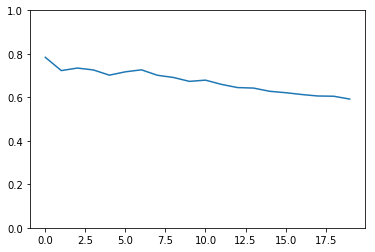

In [18]:
plt.plot(test_accuracies)
plt.ylim(ymin=0, ymax=1)
plt.show()

In [19]:
print(np.mean(test_accuracies))

0.6735782758525138


In [ ]:
%store -r DB1_test_accuracies
plt.plot(test_accuracies, color='g')
plt.plot(DB1_test_accuracies, color='b')
plt.ylim(ymin=0, ymax=1)
plt.show()

In [ ]:
plt.hist(tuner.appended_task_list[-1].train.weights[0 : tuner.appended_task_list[-2].train.weights.shape[0]], bins='auto')

In [ ]:
if use_tpu:
    sess.run(tpu.shutdown_system())

sess.close()

In [ ]:
import shelve
filename='code_state.bak'
my_shelf = shelve.open(filename,'n') # 'n' for new

for key in dir():
    try:
        my_shelf[key] = globals()[key]
    except TypeError:
        #
        # __builtins__, my_shelf, and imported modules can not be shelved.
        #
        print('ERROR shelving: {0}'.format(key))
my_shelf.close()